#GradCam Visualisation

In [28]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import imutils
import cv2

In [29]:
#Connect Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [94]:
#Take input the pretrianed model
from keras.models import load_model
model=load_model("/content/gdrive/MyDrive/ALLISI/TrueTOTAL200dataResnset.h5")

In [113]:
#Choose the file to predict and give the path
orig=cv2.imread("/content/Filtered.jpg")
resized=cv2.resize(orig,(224,224))

In [114]:
import matplotlib.pyplot as plt
image=resized
image1=image.copy()
image=img_to_array(image)
image=np.expand_dims(image,axis=0)

In [115]:
#Prediction
preds=model.predict(image)
i=np.argmax(preds[0])
print(i)
if i==0:
  decision="Covid"
elif i==1:
  decision="Lung Opacity"
elif i==2:
  decision="Normal"
else:
  decision="Pneumonia"
print(decision)

2
Normal


In [116]:
def decode_predictions(preds, top=1, class_list_path=None):
    import json
    if len(preds.shape) !=2:
        raise ValueError('`decode_predictions` expects '
                     'a batch of predictions '
                     '(i.e. a 2D array of shape (samples, 1000)). '
                     'Found array with shape: ' + str(preds.shape))
    #CLASS_INDEX = json.load(open(class_list_path))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result =pred[i]
        #result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [117]:
# decode the ImageNet predictions to obtain the human-readable label
decoded = decode_predictions(preds,top=1,class_list_path=None)
decoded=decoded[0]*100

In [118]:
class gradcam:
  def __init__(self,model,classIdx,layername=None):
    self.model=model
    self.classIdx=classIdx
    self.layername=layername
    if self.layername is None:
      self.layername=self.find_target_layer()
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output.shape)==4:
        return layer.name
    raise ValueError("COuld not find 4d layer")
  def compute_heatmap(self,image,eps=1e-8):
    gradModel=Model(inputs=[self.model.inputs],outputs=[self.model.get_layer(self.layername).output, self.model.output])
    with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
    return (heatmap, output)

In [119]:
cam = gradcam(model, i)
heatmap = cam.compute_heatmap(image)

In [120]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

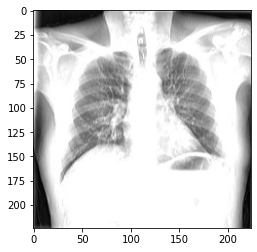

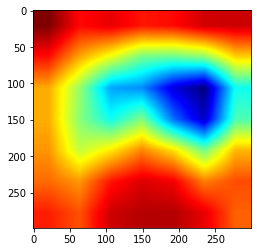

Normal : 74.83240365982056


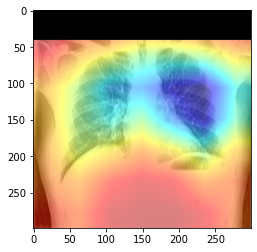

In [121]:
# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
#cv2.putText(output,label=, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
import matplotlib.pyplot as plt

# display the original image and resulting heatmap and output image
# to our screen
#output = np.vstack([orig, heatmap, output])
#output = imutils.resize(output, height=700)
plt.imshow(image1)
plt.show()
plt.imshow(heatmap)
plt.show()
print(decision,":",decoded)
plt.imshow(output)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data
import cv2

# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
def concat_tile(im_list_2d):
	return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

#im1_s = cv2.resize(im1, dsize=(0, 0), fx=0.5, fy=0.5)
im_tile = concat_tile([[LL, LH],[HL,HH]])
temp = [coeffs2[0], coeffs2[1][0], coeffs2[1][1], coeffs2[1][2]]
#plt.imshow(im_tile,'gray')
#plt.show()
plt.imsave('image.png',im_tile,cmap='gray')